In [72]:
import numpy as np
import matplotlib.pyplot as plt
from models.training import easyTrainer, weights_to_dataset
from models.nODE import nODE, make_nODE_from_parameters
import scipy
import torch

In [4]:
# 5D repressilator

In [91]:
dim = 7

gamma = - np.ones([dim])
Wout = 2 * np.eye(dim)
Win = np.zeros([dim, dim])
for i in range(dim - 1):
    Win[i, i + 1] = -1
Win[dim - 1, 0] = -1
bin, bout = 2 * np.ones([dim, 1]), 2 * np.ones([dim, 1])

node_5Drepr = make_nODE_from_parameters(gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)


In [ ]:
# generate random networks on 2 nodes

In [101]:
rng1 = np.random.default_rng()
rng1.standard_normal([2,2])

array([[0.11899321, 1.44942017],
       [0.79702904, 2.00677987]])

In [154]:
def rand_dim(dim):
    return rng1.standard_normal(dim)

In [155]:
def adjacency_matrix(W):
    if isinstance(W,np.ndarray):
        W = torch.from_numpy(W)
    values_log_W = torch.sort(torch.log(torch.abs(W.flatten())))[0]
    threshold = values_log_W[torch.sort(values_log_W[1:] - values_log_W[:-1])[1][-1] + 1]
    W_bool_activation = (W >= torch.exp(threshold))
    W_bool_repr = (W <= -torch.exp(threshold))
    adjacency_mat = W_bool_activation.float() - W_bool_repr.float()
    return adjacency_mat

In [156]:
def random_zeros(mat, threshold = 0.7):
    rand_mat = np.random.uniform(size = np.shape(mat))
    bool_mask = rand_mat > threshold
    return np.multiply(mat, bool_mask)

In [188]:
def randomize_adjacency(adjacency, threshold = 0.7):
    noisy_adjacency = np.abs(adjacency)
    flipped_adjacency = -1 + noisy_adjacency

    # randomly remove  connections
    rand_mat = np.random.uniform(size = np.shape(adjacency))
    bool_mask = rand_mat > (1-threshold)
    print(bool_mask)
    noisy_adjacency = np.multiply(noisy_adjacency, bool_mask)
    print(noisy_adjacency)
    
    #randomly add unwanted connections
    rand_mat = np.random.uniform(size = np.shape(adjacency))
    bool_mask = rand_mat > threshold    
    print(bool_mask)
    noisy_adjacency += np.multiply(flipped_adjacency, bool_mask)

    return noisy_adjacency    

In [173]:
dim = 2
n_data = 50

gamma = - np.abs(rand_dim(dim))
Wout = rand_dim([dim, dim])
Win = rand_dim([dim, dim])
bin, bout = rand_dim(dim), rand_dim(dim)

Win = random_zeros(Win, threshold = 0.5)
Wout = random_zeros(Wout)

adjacency = adjacency_matrix(np.matmul(Wout, Win))

node_2D = make_nODE_from_parameters(gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)

u0 = rand_dim([n_data, dim])
uT = node_2D.trajectory(torch.from_numpy(u0).float()).detach().numpy()[-1,:,:]

approx_adjacency = randomize_adjacency(adjacency)

In [174]:
np.shape(uT)

(50, 2)

In [175]:
adjacency

tensor([[ 0.,  0.],
        [ 1., -1.]])

In [190]:
randomize_adjacency(adjacency)

[[ True  True]
 [ True  True]]
tensor([[0., 0.],
        [1., 1.]])
[[False  True]
 [ True  True]]


tensor([[ 0., -1.],
        [ 1.,  1.]])

In [119]:
dim = 3
time_end = 20

gamma = - np.ones([dim])
Wout = 2 * np.eye(dim)
Win = np.zeros([dim, dim])
for i in range(dim - 1):
    Win[i, i + 1] = -1
Win[dim - 1, 0] = -1
bin, bout = 2 * np.ones([dim, 1]), 2 * np.ones([dim, 1])

node_3Drepr = make_nODE_from_parameters(gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)

traj = node_3Drepr.trajectory(torch.tensor([1,2,3.]), time_interval=[0,time_end], n_evals=time_end*10)

print(node_3Drepr)

Gx + w1tanh(w2x(t)+b2)+b1    over the interval [0, 1]
G = [-1. -1. -1.], W1 = [[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]],        b1 = [[2.]
 [2.]
 [2.]]

W2= [[ 0. -1.  0.]
 [ 0.  0. -1.]
 [-1.  0.  0.]],        b2 = [[2.]
 [2.]
 [2.]]




In [120]:
dim = 3

gamma = - np.ones([dim])
Wout = 2 * np.eye(dim)
Win = np.zeros([dim, dim])
for i in range(dim - 1):
    Win[i, i + 1] = -1
Win[dim - 1, 0] = -1
Win[0,2] = -0.05
bin, bout = 2 * np.ones([dim, 1]), 2 * np.ones([dim, 1])

node_3Drepr_prime = make_nODE_from_parameters(gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)

traj_prime = node_3Drepr_prime.trajectory(torch.tensor([1,2,3.]), time_interval=[0,time_end], n_evals=time_end*10)
print(node_3Drepr_prime)

Gx + w1tanh(w2x(t)+b2)+b1    over the interval [0, 1]
G = [-1. -1. -1.], W1 = [[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]],        b1 = [[2.]
 [2.]
 [2.]]

W2= [[ 0.   -1.   -0.05]
 [ 0.    0.   -1.  ]
 [-1.    0.    0.  ]],        b2 = [[2.]
 [2.]
 [2.]]




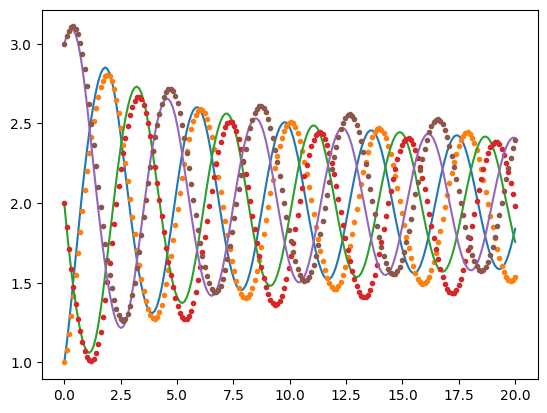

In [121]:
time = np.linspace(0, time_end, traj.size()[0])
for i in range(traj.size()[1]):
    plt.plot(time[:], traj[:,i].detach().numpy())
    plt.plot(time[:], traj_prime[:,i].detach().numpy(), '.')

Knock down by repressing the second gene (aka setting b_out[2] large and negative)

In [130]:
dim = 3
time_end = 20

gamma = - np.ones([dim])
Wout = 2 * np.eye(dim)
Win = np.zeros([dim, dim])
for i in range(1, dim):
    Win[i, i - 1] = -1
Win[0, dim - 1] = -1
bin, bout = 3 * np.ones([dim, 1]), 3 * np.ones([dim, 1])

# knock down
Win[1, :] = 0
bout[1] = - np.tanh(bin[1]) * 2

node_3Drepr = make_nODE_from_parameters(gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)

traj = node_3Drepr.trajectory(torch.tensor([10,0,3.]), time_interval=[0,time_end], n_evals=time_end*10)

print(node_3Drepr)

Gx + w1tanh(w2x(t)+b2)+b1    over the interval [0, 1]
G = [-1. -1. -1.], W1 = [[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]],        b1 = [[ 2.       ]
 [-1.9280552]
 [ 2.       ]]

W2= [[ 0.  0. -1.]
 [ 0.  0.  0.]
 [ 0. -1.  0.]],        b2 = [[2.]
 [2.]
 [2.]]




In [131]:
dim = 3

gamma = - np.ones([dim])
Wout = 2 * np.eye(dim)
Win = np.zeros([dim, dim])
for i in range(1, dim):
    Win[i, i - 1] = -1
Win[0, dim - 1] = -1
Win[2, 0] = -0.1
bin, bout = 2 * np.ones([dim, 1]), 2 * np.ones([dim, 1])

# knock down
Win[1, :] = 0
bout[1] = - np.tanh(bin[1]) * 2

node_3Drepr_prime = make_nODE_from_parameters(gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)

traj_prime = node_3Drepr_prime.trajectory(torch.tensor([10,0,3.]), time_interval=[0,time_end], n_evals=time_end*10)
print(node_3Drepr_prime)

Gx + w1tanh(w2x(t)+b2)+b1    over the interval [0, 1]
G = [-1. -1. -1.], W1 = [[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]],        b1 = [[ 2.       ]
 [-1.9280552]
 [ 2.       ]]

W2= [[ 0.   0.  -1. ]
 [ 0.   0.   0. ]
 [-0.1 -1.   0. ]],        b2 = [[2.]
 [2.]
 [2.]]




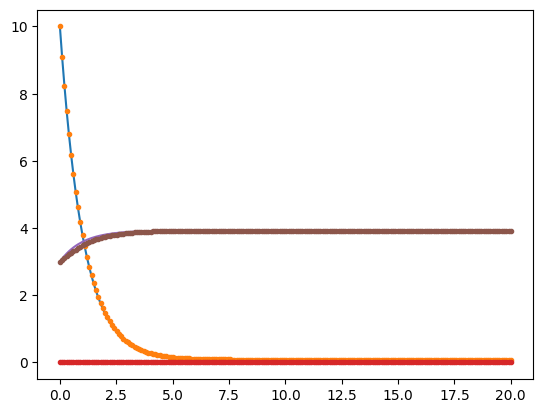

In [132]:
time = np.linspace(0, time_end, traj.size()[0])
for i in range(traj.size()[1]):
    plt.plot(time[:], traj[:,i].detach().numpy())
    plt.plot(time[:], traj_prime[:,i].detach().numpy(), '.')